<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#librabries
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
import kagglehub
import os
import shutil
import warnings
from sklearn.model_selection import train_test_split
import time
warnings.filterwarnings('ignore')


In [ ]:
# Download dataset
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
print("Path to dataset files:", path)

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

#Count
ben = len(os.listdir(os.path.join(train_path, "Benign"))) + len(os.listdir(os.path.join(test_path, "Benign")))
mal = len(os.listdir(os.path.join(train_path, "Malignant"))) + len(os.listdir(os.path.join(test_path, "Malignant")))

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

image_size = (224, 224)
batch_size = 32

subdirectories = os.listdir(train_path)

train_data_dir = './train_data'
validation_data_dir = './validation_data'

os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(validation_data_dir, exist_ok=True)

# Split images from each class folder
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_path, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_path, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_path, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


# Data generators

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Print class counts

print("Number of samples in training set:", len(train_generator.classes))
print("Number of samples in validation set:", len(validation_generator.classes))

100%|██████████| 79.4M/79.4M [00:03<00:00, 24.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1
Number of images benign: 7289
Number of images malignant: 6590
Found 8315 images belonging to 2 classes.
Found 3564 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Number of samples in training set: 8315
Number of samples in validation set: 3564


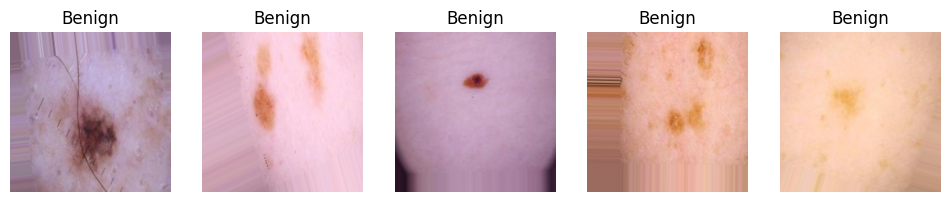

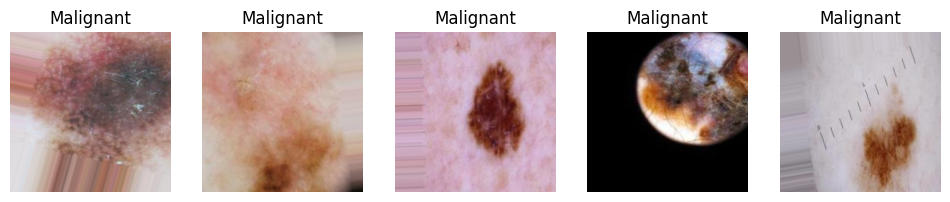

In [ ]:
# Plot sample images per class

num_images_per_class = 5
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Loop through batches until samples from all classes are plotted
for class_index, class_label in class_labels.items():
    class_images = []

    for batch_images, batch_labels in train_generator:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl[class_index] == 1:
                class_images.append(img)
                if len(class_images) == num_images_per_class:
                    break
        if len(class_images) == num_images_per_class:
            break

    plt.figure(figsize=(12, 10))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

In [ ]:
# EfficientNetB0 model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

input_shape = (224, 224, 3)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, pooling='max')
x = base_model.output
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = models.Model(inputs=base_model.input, outputs=output)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 4,171,774 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Training the model

start_time = time.time()
history1 = model.fit(train_generator, epochs=15, validation_data=validation_generator)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 218s 557ms/step - accuracy: 0.6942 - loss: 3.4719 - val_accuracy: 0.5292 - val_loss: 3.6531
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.7963 - loss: 2.6583 - val_accuracy: 0.5943 - val_loss: 3.0429
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.8215 - loss: 2.4871 - val_accuracy: 0.7525 - val_loss: 2.5372
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 85s 328ms/step - accuracy: 0.8355 - loss: 2.3557 - val_accuracy: 0.7688 - val_loss: 2.4448
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - accuracy: 0.8482 - loss: 2.2746 - val_accuracy: 0.5777 - val_loss: 2.6373
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 85s 326ms/step - accuracy: 0.8520 - loss: 2.1995 - val_accuracy: 0.7197 - val_loss: 2.4058
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.8704 - loss: 2.0903 - val_accuracy: 0.7217 - val_loss: 2.3385
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 88s 336ms/step - accuracy: 0.8585 - loss: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)

# Print the test accuracy
print("Train Accuracy:", train_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.3759 - loss: 113.1307
Test Accuracy: 0.5074999928474426
260/260 ━━━━━━━━━━━━━━━━━━━━ 85s 327ms/step - accuracy: 0.5144 - loss: 79.9348
Train Accuracy: 0.5116055607795715


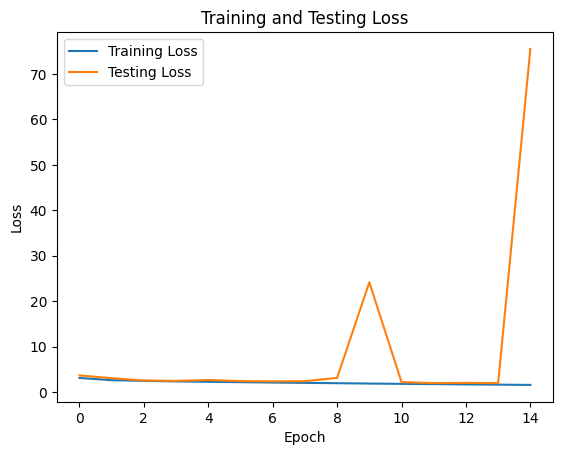

In [ ]:
#plot the loss in each epoch
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

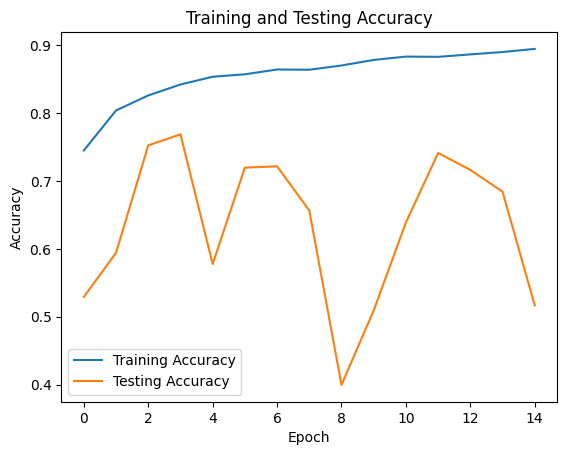

In [ ]:
#plot the accuracy in each epoch
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
#confusion matrix
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('-------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step
Confusion Matrix:
[[294 706]
 [279 721]]
-------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.29      0.37      1000
           1       0.51      0.72      0.59      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.51      0.51      0.48      2000



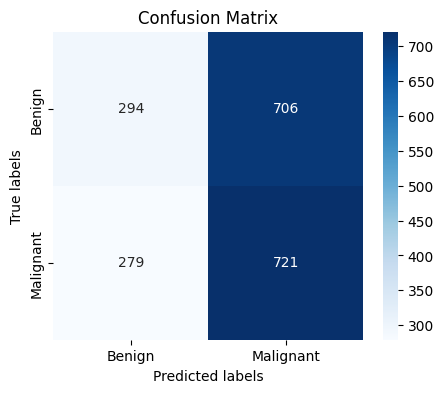

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()